In [1]:
import Pkg; Pkg.add(["Plots"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; gr(); default(l=5, size=(900,550), label=false);
using Printf;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

**(follow along: <https://tinyurl.com/gtcse6643lec17>)**

# Cholesky factorization & LU performance

**1. Hermitian postive definite matrices**

**2. Cholesky factorization**

**3. Cholesky factorization analysis**

**4. LU performance**

## Symmetric Positive Definite / Hermitian Positive Definite Matrices

### Review: Hermitian

> A matrix $A\in \mathbb{C}^{m \times m}$ is Hermitian if

$$\large A^* = A \quad \Leftrightarrow a_{ij} = \bar{a}_{ji} \text{ for all } i,j.$$

**Week 1:** What can we say about $A$'s eigenvalues?

They are real.

**Week 1:** What can we say about eigenvectors of distinct eigenvalues?

They are orthogonal.

### Positive Definiteness

Matrix $A\in \mathbb{C}^{m \times m}$ is _positive definite_ if for every $x\neq 0\in\mathbb{C}^{m}$

$$\Large x^* A x > 0.$$

### Together: Hermitian positive definite AKA h.p.d. (symmetric positive definite AKA s.p.d.)

$$\Large A = A^*, \quad x^* A x > 0 \quad \text{ for all } x\neq 0\in\mathbb{C}^{m} \quad \Leftrightarrow \quad A \succ 0.$$

**Q:** What can be said about the eigenvalues of $A$?

They are all positive.

### Random s.p.d. matrices

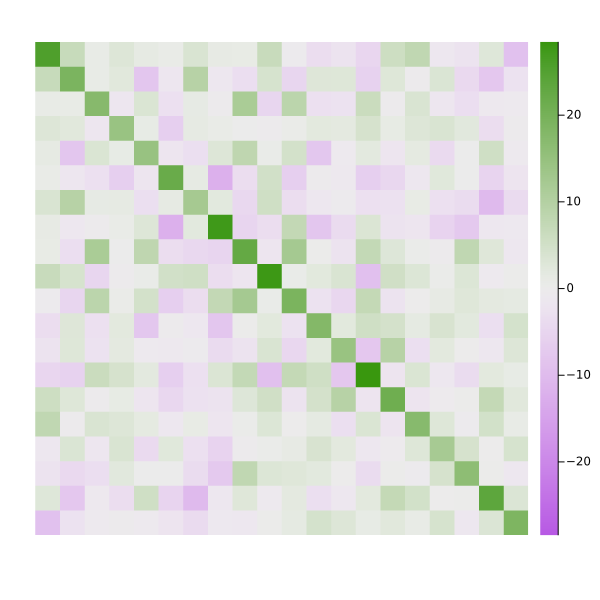

In [18]:
m = 20
B = randn(m,m)
A = B' * B
scale = maximum(abs.(A))
imshow(A, clim=(-scale,scale), size=(600,600))

**Q:** Will there ever be a negative on the diagonal?

No: $$\Large a_{kk} = e_k^* A e_k > 0.$$

### What about these matrices?

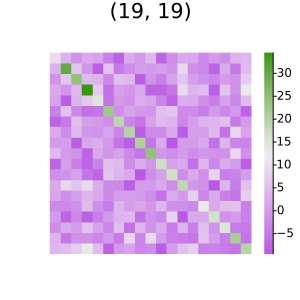

In [19]:
m = 20
n = 19
B = randn(m, n)
A1 = B' * B
imshow(A1, size=(300,300), title="$(size(A1))")

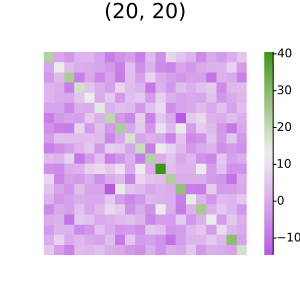

In [20]:
m = 19
n = 20
B = randn(m, n)
A2 = B' * B
imshow(A2, size=(300,300), title="$(size(A2))")

In [7]:
minimum(eigen(A1).values)

0.0009748539292860724

In [8]:
minimum(eigen(A2).values)

7.495124556580332e-16

$A_2$ is symmetric positive _semidefinite_, $x^* A_2 x \geq 0.$

**Claim.** Suppose $A \in \mathbb{C}^{m \times m}$ is s.p.d. and suppose $B \in \mathbb{C}^{m \times n}$, ($m \geq n$) has rank $n$.  Then

$$\Large B^* A B \succ 0.$$

_Proof._

- Hermitian by inspection

- If $x \neq 0$, 

$$\Large x^* (B^* A B) x = (B x)^* A (B x) > 0,$$

because $B x \neq 0$ ($B$ is full rank).

- Hermitian / symmetric is easy to verify

- h.p.d. / s.p.d. can be verified by singular values / eigenvalues (the same thing!), but is often guaranteed by the underlying problem:

  - Inner product on $\mathbb{C}^{m} \cong$ h.p.d. matrices,
  
  $$\langle x, y \rangle_{A} = x^* A y.$$

  - The smooth optimization problem $\min_x f(x)$ has a unique local minimum at $\hat{x}$ iff
  
  $$\nabla^2 f(\hat{x}) \succ 0.$$

**Claim.** If $A$ is h.p.d., then $A$ has an LU factorization without pivoting.

_Proof._

$$
B = 
\begin{bmatrix}
I_{k} \\ 0
\end{bmatrix}
$$

## Cholesky Factorization

$$A = A^*, \quad A \succ 0 \quad \Rightarrow \quad A = R^* R, \quad R \text{ upper triangular}, \quad r_{jj} >  0 \text{ for all } j$$ 

### After one step of LU

$$
A = 
\underbrace{
\begin{bmatrix}
1 & 0 \\
\underbrace{a_{2:m,1}}_{w} a_{11}^{-1} & I_{m-1}
\end{bmatrix}}
_{L_1^{-1}}
\underbrace{
\begin{bmatrix}
a_{11} & \underbrace{a_{1,2:m}}_{w^*} \\
0 & A_{2:m,2:m} - (w a_{11}^{-1}) w^*
\end{bmatrix}}_{U^{(1)}}
$$

$$
A = 
\underbrace{
\begin{bmatrix}
1 & 0 \\
w a_{11}^{-1} & I_{m-1}
\end{bmatrix}}
_{L_1^{-1}}
\begin{bmatrix}
a_{11} & 0 \\
0 & A_{2:m,2:m} - w a_{11}^{-1} w^*
\end{bmatrix}
\underbrace{
\begin{bmatrix}
1 & a_{11}^{-1} w^* \\ 0 & I_{m-1}
\end{bmatrix}}
_{L_1^{-*}}
$$

$$
A = 
\underbrace{
\begin{bmatrix}
1 & 0 \\
w a_{11}^{-1} & I_{m-1}
\end{bmatrix}}
_{L_1^{-1}}
\begin{bmatrix}
a_{11} & 0 \\
0 & A_{2:m,2:m} - w a_{11}^{-1} w^*
\end{bmatrix}
\underbrace{
\begin{bmatrix}
1 & a_{11}^{-1} w^* \\ 0 & I_{m-1}
\end{bmatrix}}
_{L_1^{-*}}
$$

$$
A = 
\underbrace{
\begin{bmatrix}
1 & \\
w a_{11}^{-1} & I_{m-1}
\end{bmatrix}}
_{L_1^{-1}}
\begin{bmatrix}
\sqrt{a}_{11} & \\ & I_{m-1} 
\end{bmatrix}
\begin{bmatrix}
1 & 0 \\
0 & A_{2:m,2:m} - w a_{11}^{-1} w^*
\end{bmatrix}
\begin{bmatrix}
\sqrt{a}_{11} & \\ & I_{m-1} 
\end{bmatrix}
\underbrace{
\begin{bmatrix}
1 & a_{11}^{-1} w^* \\ 0 & I_{m-1}
\end{bmatrix}}
_{L_1^{-*}}
$$

$$
A = 
\underbrace{
\begin{bmatrix}
\sqrt{a_{11}} & \\
w  \frac{1}{\sqrt{a_{11}}} & I_{m-1}
\end{bmatrix}}
_{R_1^*}
\begin{bmatrix}
1 & 0 \\
0 & A_{2:m,2:m} - w a_{11}^{-1} w^*
\end{bmatrix}
\underbrace{
\begin{bmatrix}
\sqrt{a_{11}} & \frac{1}{\sqrt{a_{11}}} w^* \\ 0 & I_{m-1}
\end{bmatrix}}
_{R_1 :=}
$$

### After one step of Cholesky factorization

$$
\underbrace{
\begin{bmatrix}
\frac{1}{\sqrt{a_{11}}} & \\
- w  \frac{1}{a_{11}} & I_{m-1}
\end{bmatrix}}
_{R_1^{-*}}
A
\underbrace{
\begin{bmatrix}
\frac{1}{\sqrt{a_{11}}} & -\frac{1}{a_{11}} w^* \\ 0 & I_{m-1}
\end{bmatrix}}
_{R_1^{-1}}
=
\begin{bmatrix}
1 & 0 \\
0 & A_{2:m,2:m} - w a_{11}^{-1} w^*
\end{bmatrix}
$$

**Claim.** $A_{2:m,2:m} - w a_{11}^{-1} w^*$ is positive definite.

_Proof._

$$
A_{2:m,2:m} - w a_{11}^{-1} w^*
=
\underbrace{
\begin{bmatrix}
- w  \frac{1}{a_{11}} & I_{m-1}
\end{bmatrix}}
_{B^{*}}
A
\underbrace{
\begin{bmatrix}
-\frac{1}{a_{11}} w^* \\ I_{m-1}
\end{bmatrix}}
_{B},
$$

and $B$ is full rank.

**T&B Theorem 23.1.** Every h.p.d. matrix $A \in \mathbb{C}^{m \times m}$ has a unique Cholesky factorization.

_Proof._

The first step on the previous slide shows that the factorization exists by induction.

The uniqueness also follows by construction: the first element of $R_1$ can only be $\sqrt{a_{11}}$, and so on.

### Full Cholesky factorization

$$\Large A = \underbrace{R_1^* R_2^* \cdots R_m^*}_{R^*} \underbrace{R_m \cdots R_2 R_1}_{R}.$$

In [22]:
function cholesky_two_loops(A)
    R = triu(copy(A))
    m = size(A)[1]
    for k = 1:m
        for j = k+1:m # symmetric rank one update
            R[j,j:m] -= R[k,j:m] * R[k,j] / R[k,k]
        end
        R[k,k:m] ./= sqrt(R[k,k]) # leading diagonal value
    end
    return R
end

cholesky_two_loops (generic function with 1 method)

In [10]:
m = 100
B = randn(m,m); A = B' * B
R = cholesky_two_loops(A)
norm(R' * R - A) / norm(A)

2.7204235526918325e-16

- $\sim \frac{1}{3} m^3$ flops (half of LU, exploiting symmetry of $A$)

### Exercise

**T&B Exercise 23.1.** Let $A$ be a nonsingular square matrix and let $A = QR$ and $A^* A = U^*U$ be QR and Cholesky factorizations, respectively, with the usual normalizations $r_{jj}, u_{jj} > 0.$  Is it true that $R = U$?

$$
A^* A = (Q R)^* (QR) = R^* Q^* Q R = R^* R.
$$

### Cholesky Stability and Conditioning

$$A = A^*, \quad A \succ 0, \quad A = R^* R, \quad R = \mathrm{triu}(R), \quad r_{jj} > 0.$$

**Claim.**

$$\|R\|_2 = \|A\|_2^{1/2}.$$

_Proof._

$$R = U \Sigma V^*$$

$$A = R^* R = V \Sigma U^* U \Sigma V^* = \underbrace{V \Sigma^2 V^*}_{\text{SVD of }A}.$$

Largest singular value of $A$ is $\sigma_1^2$.

### Cholesky stability

The factor $R$ is small without pivoting.  This was not the case with general LU.

$$\frac{\|\delta A\|}{\|L\| \|U\|} = O(\epsilon).$$

**T&B Theorem 23.2.** Let  $A \in \mathbb{C}^{m \times m}$ be h.p.d., and let a Cholesky factorization of $A$ be computed by `cholesky_two_loops` on a computer satisfying the floating point axioms.

For all sufficiently small $\epsilon_{\text{machine}}$, this process is guaranteed to run to completion (no negative / zero pivots), generating a computed $\tilde{R}$ such that

$$
\tilde{R}^* \tilde{R} = A + \delta A, \quad \frac{\|\delta A\|}{\|A\|} = O(\epsilon_{\text{machine}})
$$

for some $\delta A$.

### Cholesky backward error analysis

$$
\frac{\|\tilde{R} - R\|}{\|R\|} = O(\kappa(A) \epsilon_{\text{machine}}).
$$

### Systems of equations

**T&B Theorem 23.3.** The solution of h.p.d. system $Ax = b$ via Cholesky factorization is backward stable, generating $\tilde{x}$ that satisfies

$$(A + \Delta A) \tilde{x} = b, \quad \frac{\|\Delta A\|}{\|A\|} = O(\epsilon_{\text{machine}})$$

for some $\Delta A.$

Why is this stable when the normal equations sometimes aren't?

## LU Factorization Performance

### Recall: Householder QR is not the final word in QR factorization

| algorithm | acts on | stability | behavior | cost | static comm. rounds | online comm. rounds |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| classical Gram-Schmidt | $$Q$$ | ❌ | left-looking | $$\sim 2mn^2$$ | $$2n$$ | $$2n$$ |
| modified Gram-Schmidt | $$Q$$ | ⚠️ | right-looking | $$\sim 2mn^2$$ | $$2n$$ | $$\sim\textstyle\frac{1}{2}n^2$$ |
| Householder QR | $$R$$ | ✅ | down-looking | $$\sim 2mn^2 - \textstyle{\frac{2}{3}}n^3$$ | $$2n$$ | $$\sim\textstyle\frac{1}{2}n^2$$ |
| Tall Skinny QR (TSQR) | $$R$$ | ✅ | recursive | $$\sim 2mn^2 + \textstyle{\frac{2}{3}}n^3 p \log p$$ | $$\log p$$ | $$-$$ |
| Cholesky QR | $$A^*A$$ | ❌ | Cholesky | $$\sim 2mn^2 + \textstyle{\frac{1}{3}}n^3p$$ | $$1$$ | $$n$$ |

### LU with Partial Pivoting is also not the final word in LU factorization

### First: Performance of LU without pivoting

Is there any difference in floating point between these two versions of LU?

In [11]:
function lu_three_loops_kij(A)
    m = size(A)[1]
    LU = copy(A)
    for k in 1:(m-1)
        for i in (k+1):m
            LU[i,k] /= LU[k,k]
            for j in (k+1):m
                LU[i,j] -= LU[i,k] * LU[k,j]
            end
        end
    end
    return LU
end

lu_three_loops_kij (generic function with 1 method)

In [12]:
function lu_three_loops_kji(A)
    m = size(A)[1]
    LU = copy(A)
    for k in 1:(m-1)
        for i in (k+1):m
            LU[i,k] /= LU[k,k]
        end
        for j in (k+1):m
            for i in (k+1):m
                LU[i,j] -= LU[i,k] * LU[k,j]
            end
        end
    end
    return LU
end

lu_three_loops_kji (generic function with 1 method)

- No difference in exact arithmetic

- No difference in floating point (same associative ordering)

- **The difference is memory access patterns**

### Memory movement is the dominant cost in most computing

- From storage to nodes
- Between nodes
- Between GPUs / sockets on a node
- From **main memory (big and slow)** to **cache (small and fast)**
- From cache to **register (tiny and fastest)**

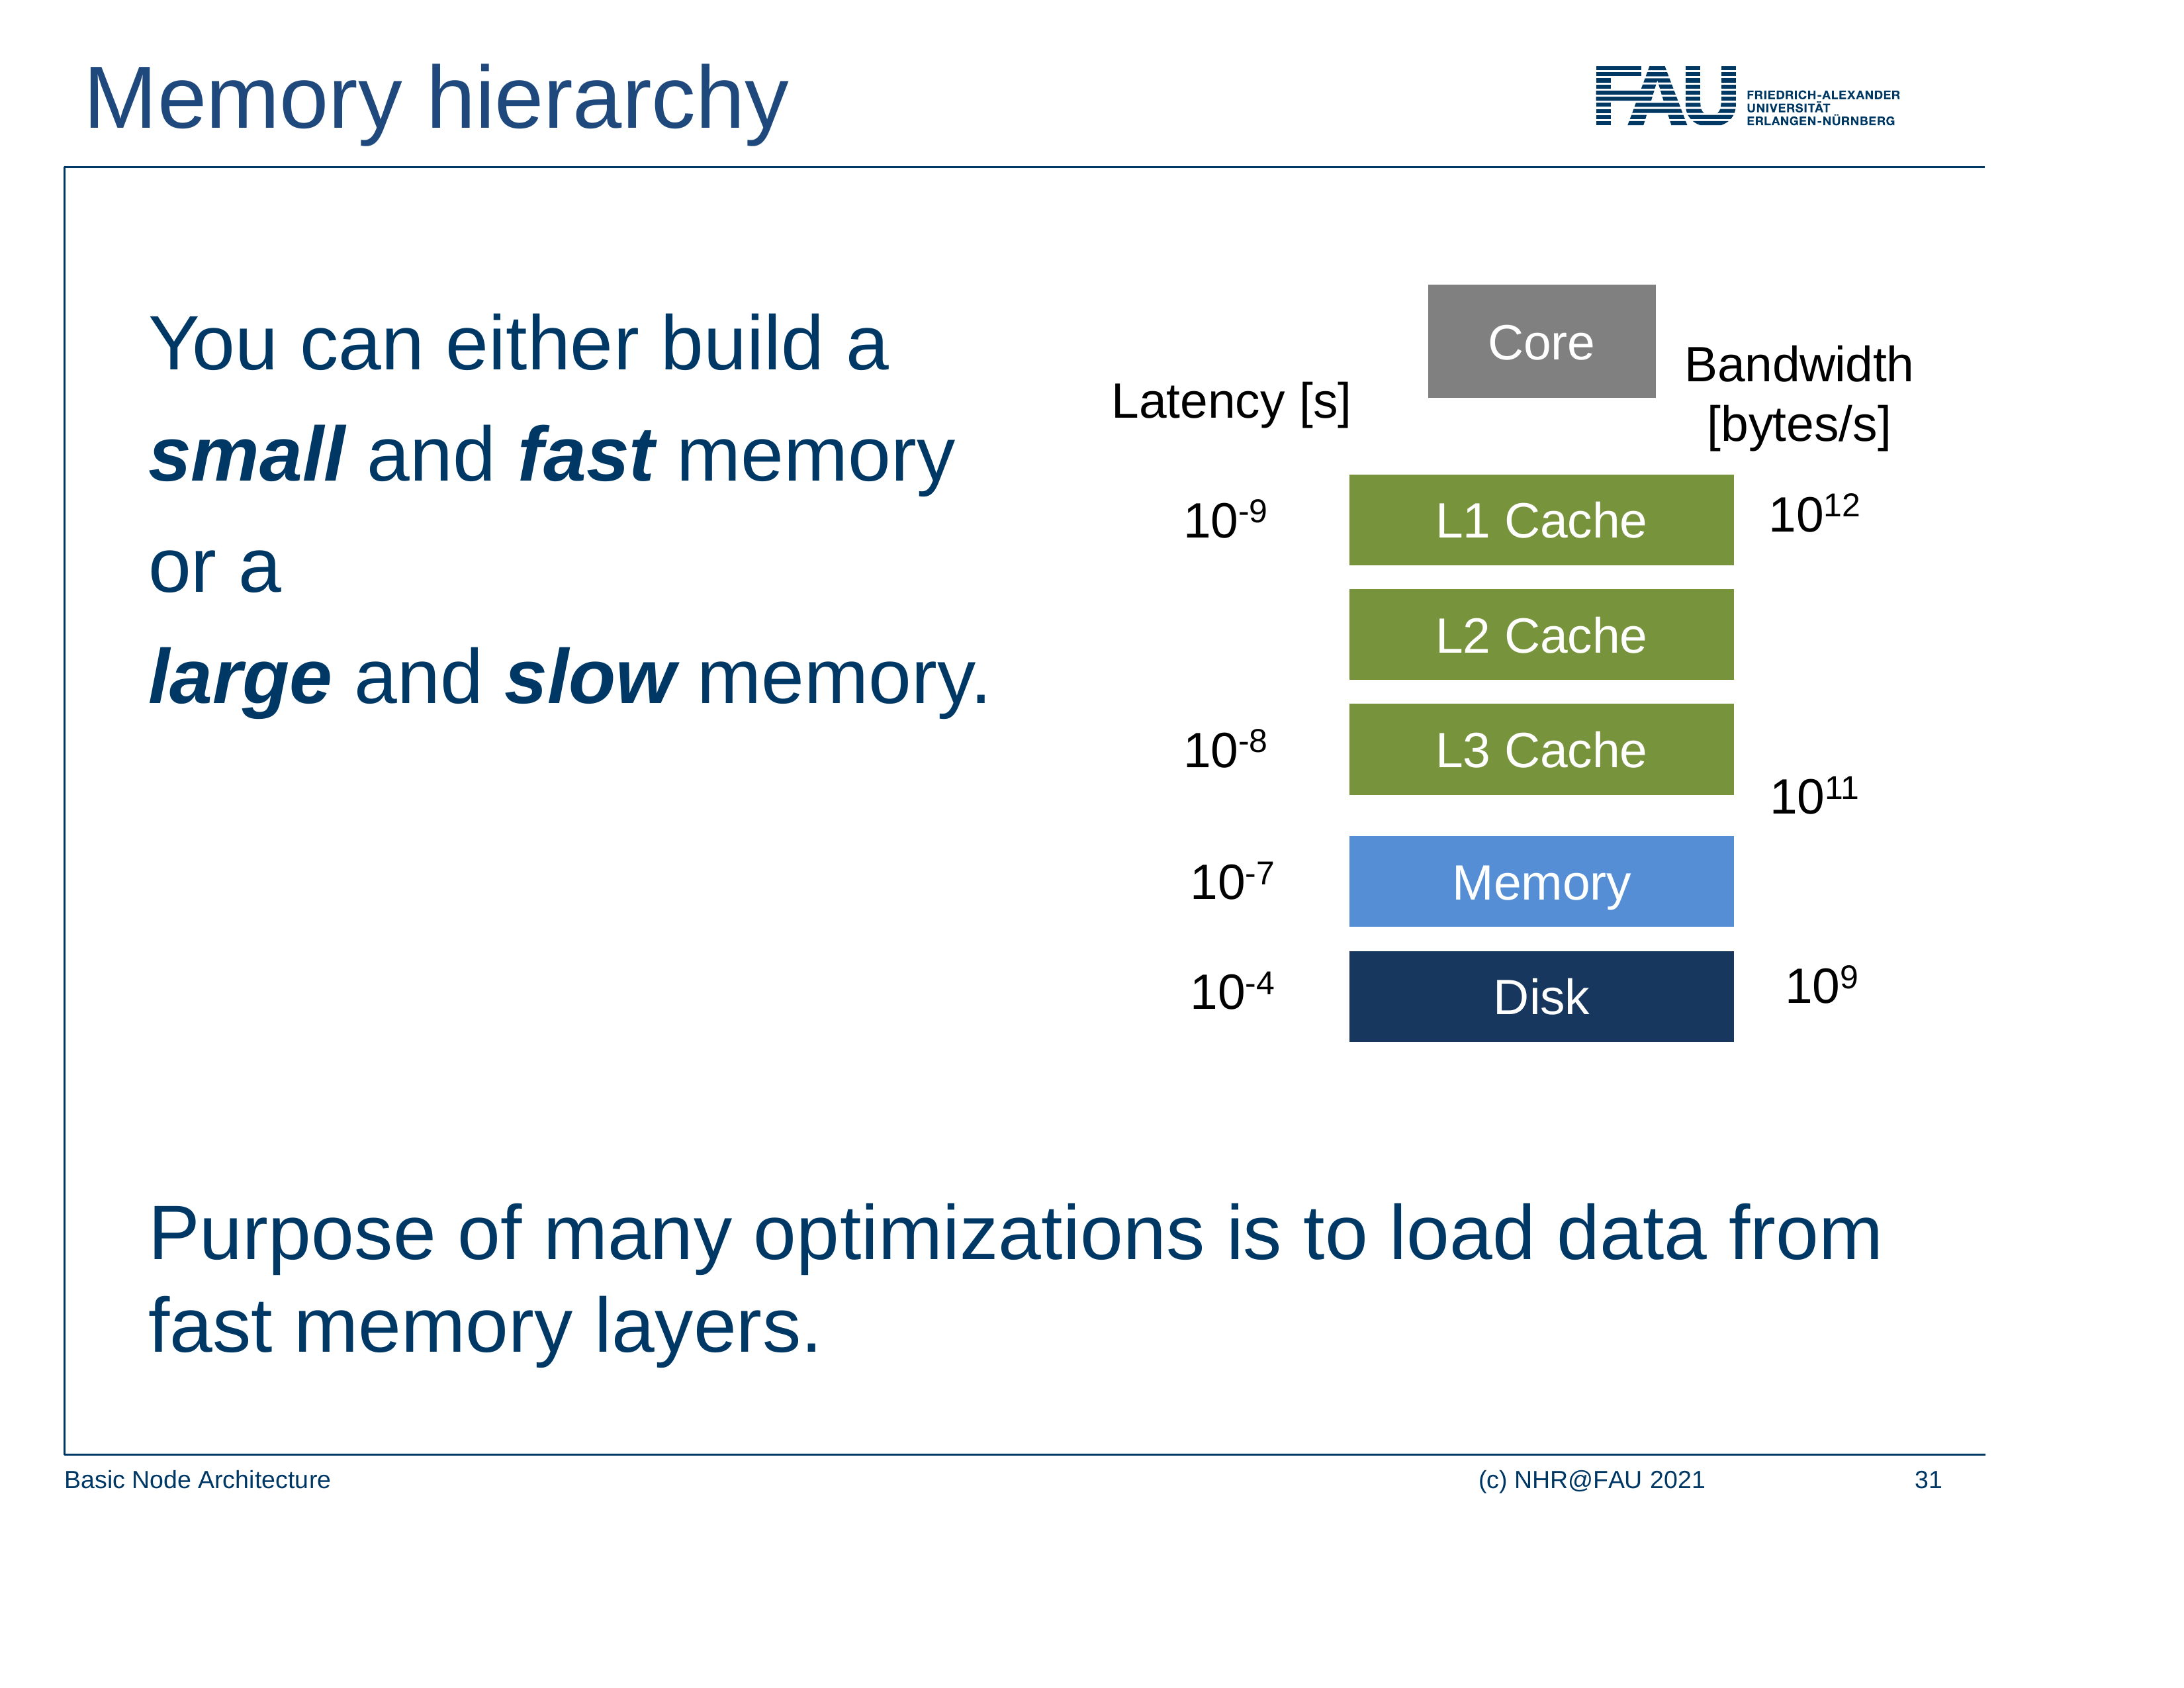

### A not-too-bad heuristic for modern computation

At peak performance, a modern computer can do ${}\sim\!100$ floating point operations in the time it takes to move one 64-bit floating point number to/from main memory

### Simplified illustration

- A machine with **slow memory** ($\infty$ size) and **fast memory** (48 numbers)
- One **fused multiply-add** (two floating point operations) per cycle on data in fast memory
- Fast memory updates in **32 number updates** (new values read from slow memory / finished values written to slow memory) every **64 cycles**

This machine does 128 operations in the time that 32 numbers are moved -- 4:1 ratio (much closer than 100:1 ratio)

### Inner product

$$z = u^* v$$

- $z$ initialized to 0 and kept in fast memory until the very end, $u$ and $v$ loaded in matching pieces

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/sched-inner.gif")
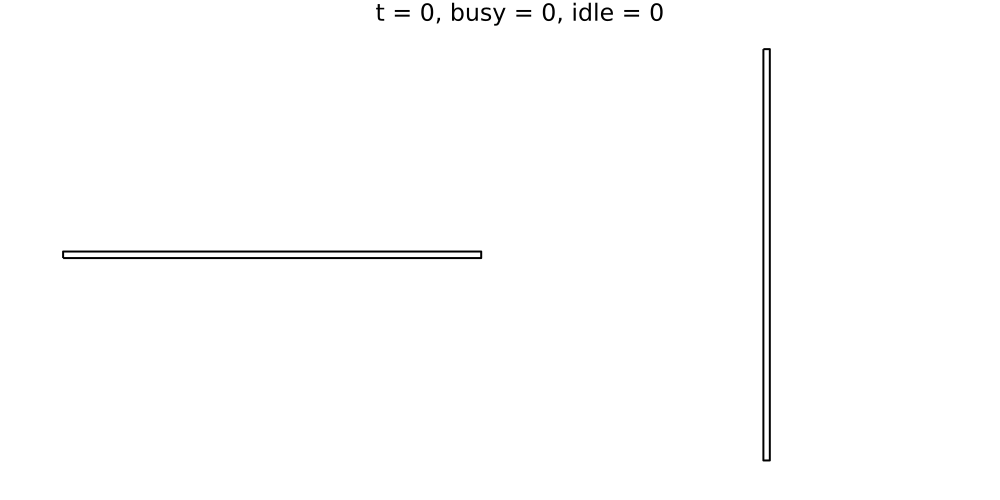

In [13]:
anim = Animation()
m = 64
b = 16
z = 64
x_plot_orig = plot([0, m, m, 0, 0], [0, 0, 1, 1, 0], l=(:black, 2), aspect_ratio = :equal, framestyle = :none)
y_plot_orig = plot([0, 1, 1, 0, 0], [0, 0, m, m, 0], l=(:black, 2), yflip=:true, aspect_ratio = :equal, framestyle = :none)
x_plot = deepcopy(x_plot_orig)
y_plot = deepcopy(y_plot_orig)
p = plot(x_plot, y_plot, layout=(1,2), size=(1000,500), plot_title="t = 0, busy = 0, idle = 0")
frame(anim, p)
k = 0
d = 0
for t = 1:div(m, b) * z
    if (t % z) == 1
        x_plot = deepcopy(x_plot_orig)
        y_plot = deepcopy(y_plot_orig)
        plot!(x_plot, [k*b, (k+1)*b, (k+1)*b, k*b, k*b], [0, 0, 1, 1, 0], st = :shape, l = 0, fillcolor=1)
        plot!(y_plot, [0,1,1,0,0], [k*b, k*b, (k+1)*b,(k+1)*b, k*b], st = :shape, l = 0, fillcolor=2)
        k += 1
    end
    if (d < k * b)
        d += 1
        plot!(x_plot, [d - 0.5], [0.5], st=:scatter, m=4, c=3)
        plot!(y_plot, [0.5], [d - 0.5], st=:scatter, m=4, c=3)
    end
    p = plot(x_plot, y_plot, layout=(1,2), size=(1000,500), plot_title="t = $t, busy = $d, idle = $(t-d)")
    frame(anim, p)
end
gif(anim, "sched-inner.gif", fps=8)

- For large $n$: if machine does $A$ flops per number moved, $(A - 1)$ out of $A$ cycles will be idle

### Outer product

$$A = u v^*$$

- Completed pieces of $A$ written out as fast as possible
- Slight machine change (30 numbers every 60 cycles)

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/sched-outer.gif")
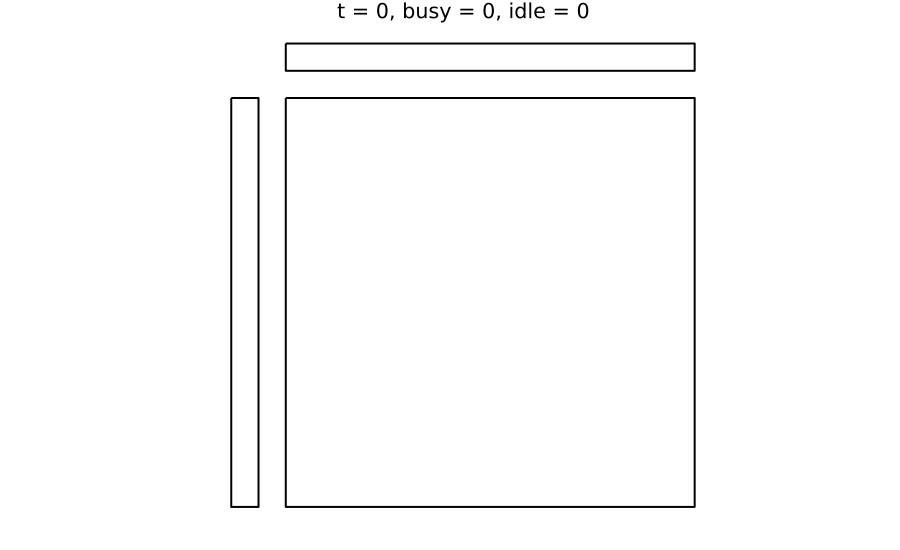

In [14]:
anim = Animation()
m = 15
n = 15
bi = 5
bj = 5
z = 60
plot_orig = plot([0, n, n, 0, 0], [-2, -2, -1, -1, -2], l=(:black, 2), aspect_ratio = :equal, yflip=:true, framestyle = :none)
plot!(plot_orig, [-2, -1, -1, -2, -2], [0, 0, m, m, 0], l=(:black, 2))
plot!(plot_orig, [0, n, n, 0, 0], [0, 0, m, m, 0], l=(:black,2))
p = deepcopy(plot_orig)
plot!(p, title="t = 0, busy = 0, idle = 0")
frame(anim, p)
ki = 1
kj = 0
kjinc = 1
d = 0
lt = 0
for t = 1:(div(m,bi) * div(n, bj) * z)
    if (t % z) == 1
        lt = t - 1
        p = deepcopy(plot_orig)
        if (kj + kjinc <= div(n, bj) && kj + kjinc > 0)
            kj += kjinc
        else
            kjinc *= -1
            ki += 1
        end
        plot!(p, [(kj-1)*bj, kj*bj, kj*bj, (kj-1)*bj, (kj-1)*bj], [-2, -2, -1, -1, -2], st=:shape, l=0, fillcolor=2)
        plot!(p, [-2, -1, -1, -2, -2], [(ki-1)*bi, (ki-1)*bi, ki*bi, ki*bi, (ki-1)*bi], st=:shape, l=0, fillcolor=1)
        plot!(p, [(kj-1)*bj, kj*bj, kj*bj, (kj-1)*bj, (kj-1)*bj], [(ki-1)*bi, (ki-1)*bi, ki*bi, ki*bi, (ki-1)*bi], st=:shape, l=0, fillcolor=4)
    end
    if t - lt <= bi * bj
        tj = (t-lt -1) % bj
        ti = div(t-lt -1, bj)
        plot!(p,[(kj-1)*bj+tj+0.5],[(ki-1)*bi+ti+0.5], st=:scatter, m=4, c=3)
        d += 1
    end
    plot!(p, title="t = $t, busy = $d, idle = $(t-d)")
    frame(anim, p)
end
gif(anim, "sched-outer.gif", fps=16)

- For large $m$, $n$:
  - $\frac{2mn \text{ flops}}{mn + n + k \text{ memops}} \sim 2 \frac{\text{flops}}{\text{memops}}$
  - if a machine does $A$ flops:number moved, $(A-2)$ out of $A$ cycles idle

### Matrix product

$$C = A B, \quad c_{ij} = \sum_{p=1}^k a_{ip} b_{pj}$$

- Devote one third of fast memory to a square block of $A$, $B$, and $C$ 
- Plot shows _iteration space_: one fused multiply add must be completed for each $(i, j, k)$

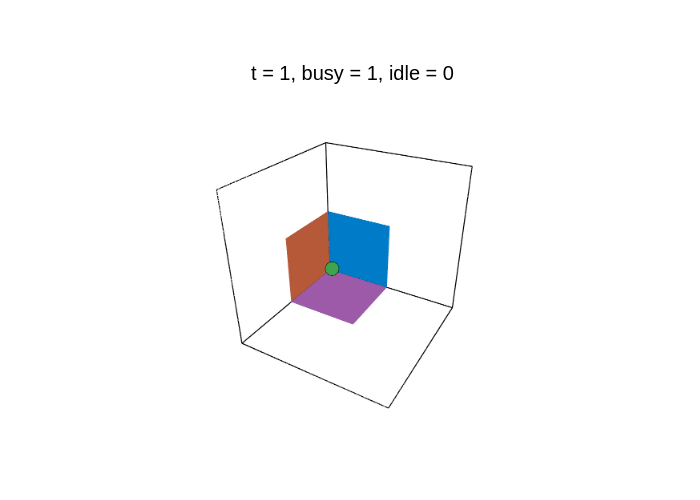

- For $m$, $n$, $k$ large enough

  - $\frac{2mnk \text{ flops}}{mn + mk + nk \text{ memops}} \geq 2 (\min \{m,n,k\})^{3/2} \frac{\text{flops}}{\text{memops}}$
  - if machine does $A$ flops:number moved, $O(1)$ out of $A$ cycles idle

### Basic Linear Algebra Subprograms (BLAS)

- **Level 1:** inputs and outputs vectors (like inner product): memory bandwidth limited (idle cycles)
- **Level 2:** blas inputs and outputs mix of vectors and matrices (like matvec, outer product): memory bandwidth limited (idle cycles)
- **Level 3:** matrix inputs and outputs (like matrix-matrix product): floating point rate limited if all dimensions are large enough (minimal idle cycles)

### HW4 Q3

> The "outer product" form of Gaussian elimination may be a better starting point if one wants to optimize computer performance

We need to go farther: we need to use **matrix-matrix multiplication** in the code for LU factorization

In [15]:
function lu_nopivot_block(A; b=16) # b = blocksize, large enough to limit idle cycles
    U = copy(A)
    m = size(A)[1]
    L = zeros(eltype(A), m, m)
    nsteps = div(m+b-1,b)
    for i = 1:nsteps
        rb = ((i-1)*b+1):min(i*b,m)  # range for this block
        rm = (min(i*b,m)+1):m        # range for the remainder
        f = lu(U[rb,rb], NoPivot())  # LU factorization of leading block
        L[rb,rb] = f.L[:,:]
        U[rb,rb] = f.U[:,:]
        L[rm,rb] = U[rm,rb] / U[rb,rb]  # blas level 3
        U[rb,rm] = L[rb,rb] \ U[rb,rm]  # blas level 3
        U[rm,rm] -= L[rm,rb] * U[rb,rm] # blas level 3
        U[rm,rb] .= 0
    end
    return L, U
end

lu_nopivot_block (generic function with 1 method)

### Not mentioned so far: partial pivoting

- For large problems in one memory domain: pivot selection / row operations are small compared to the blas level 3 operations

- For multiple memory domains (distributed memory): pivot selection / row operations is a **synchronization point** between workers.  Different pivot techniques are used to limit synchronization